# Mental Health Detection from reddit posts using NLP and LogisticRegression

### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,classification_report

In [2]:
df=pd.read_csv('improved_dataset.csv')

- In this data set we have 2838 columns and 116 number of rows

In [3]:
df.shape

(3816, 117)

In [4]:
df.columns

Index(['Unnamed: 0', 'subreddit', 'post_id', 'sentence_range', 'text', 'id',
       'label', 'confidence', 'social_timestamp', 'social_karma',
       ...
       'lex_dal_min_pleasantness', 'lex_dal_min_activation',
       'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment'],
      dtype='object', length=117)

- we have 116 columns but for our analysis we need only two columns the post text and label which is 1 or 0

- Here 1 means the statement is stressful and 0 means the statement is not stressful

In [5]:
df = df[['text', 'label']]

In [6]:
df

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1
...,...,...
3811,Frightened of ghost,0
3812,Feeling Crazy,1
3813,Feeling proud to have a friend like you,1
3814,I am in danger,0


- Checked the null values in the dataset and we found 0 null values in our dataset.

In [7]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
df.duplicated().sum()

941

In [9]:
df=df.drop_duplicates()

- we found 941 duplicate rows in our dataset so we dropped all the 15 rows.

#### StopWords
- Stop words are common words in a language, like "the", "is", and "and", which are often removed during text processing tasks because they carry little semantic meaning. Removing stop words helps improve efficiency and reduce noise in natural language processing tasks.

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\upend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Load English stopwords
english_stopwords = set(stopwords.words("english"))

def preprocess_text(text):
    # Convert text to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove digits and single characters
    text = re.sub(r'\b\w\b|\d+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text and remove stopwords
    words = [word for word in text.split() if word not in english_stopwords]
    
    # Stem the words
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a single string
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

# Apply the preprocess_text function to the "text" column of your DataFrame
df["text"] = df["text"].apply(preprocess_text)


C:\Users\upend\AppData\Local\Temp\ipykernel_20952\2361690195.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].apply(preprocess_text)


In [12]:
df['text'][1000]

'need quiet dark recov major trigger like went insid sat bathroom light left radio bedroom blare loudli move need sit littl bit thought calm back went offic came offic furiou'

In [13]:
test_df=pd.read_csv('dreaddit-test.csv')

In [14]:
test_df=test_df[['text','label']]

In [15]:
test_df['text']=test_df['text'].apply(preprocess_text)

### Splitting the data into training and testing

In [16]:
X_train=df['text']
X_test=test_df['text']
y_train=df['label']
y_test=test_df['label']

### Converting the words to numeric using tfidf

In [17]:
# Convert the Pandas Series X_train and X_test to sparse matrices using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_sparse = vectorizer.fit_transform(X_train)
X_test_sparse = vectorizer.transform(X_test)

# Convert the sparse matrices to dense NumPy arrays
X_train = X_train_sparse.toarray()
X_test = X_test_sparse.toarray()

# from sklearn.feature_extraction.text import CountVectorizer
# max_features=2000

# cou_vec=CountVectorizer(max_features=max_features, stop_words="english" , ngram_range=(1,2))

# X_train_sparse=cou_vec.fit_transform(X_train)
# X_test_sparse=cou_vec.transform(X_test)

# X_train=X_train_sparse.toarray()
# X_test=X_test_sparse.toarray()

In [18]:
X_train_sparse

<2875x7823 sparse matrix of type '<class 'numpy.float64'>'
	with 94231 stored elements in Compressed Sparse Row format>

In [19]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
from scipy import stats
z_scores = stats.zscore(X_train, axis=0)

threshold=3

outliers_indices = (z_scores > threshold).any(axis=1)
outliers_data = df[outliers_indices]

print("Outliers:")
print(outliers_indices)

Outliers:
[ True  True  True ...  True  True  True]


In [28]:
from scipy.stats import zscore
df['z_score'] = zscore(df['label'])

# Define threshold for z-score
threshold = 3

# Identify outliers
outliers = df[abs(df['z_score']) > threshold]

print("Outliers:")
print(outliers)

Outliers:
Empty DataFrame
Columns: [text, label, z_score]
Index: []


C:\Users\upend\AppData\Local\Temp\ipykernel_13432\1722318062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['z_score'] = zscore(df['label'])


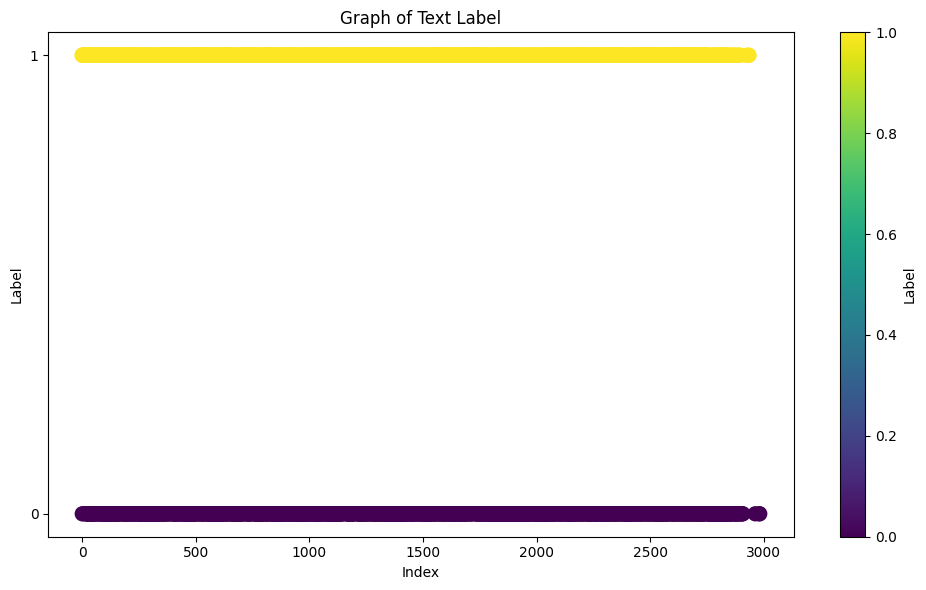

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['label'], c=df['label'], cmap='viridis', s=100)
plt.xlabel('Index')
plt.ylabel('Label')
plt.title('Graph of Text Label')
# plt.xticks(df.index, df['text'], rotation=90)  # Remove x-axis tick labels
plt.yticks([0, 1], ['0', '1'])  # Replace y-axis ticks with numbers
plt.colorbar(label='Label')
plt.tight_layout()
plt.show()

### Model Training
- Logistic Regression
- KNN Classifier
- RandomForest Classifier
- DecisionTree Classifier
- Naive Bayes Classifier
- AdaBoost Classifier
- SVM Classifier

#### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression(max_iter=200)
lr_clf.fit(X_train,y_train)

LogisticRegression(max_iter=200)

In [21]:
print('Training Score:',lr_clf.score(X_train,y_train))
print('Testing Score:',lr_clf.score(X_test,y_test))

Training Score: 0.8914782608695652
Testing Score: 0.7482517482517482


In [22]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=lr_clf,X=X_train,y=y_train,cv=10)
print("Mean Accuracy: ",accuracies.mean())
print("Standard Deviation: ",accuracies.std())

Mean Accuracy:  0.741222657762292
Standard Deviation:  0.030296750727873897


In [23]:
lr_pred=lr_clf.predict(X_test)
accuracy = accuracy_score(lr_pred,y_test)
precision = precision_score(lr_pred,y_test)
recall = recall_score(lr_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(lr_pred,y_test))

Accuracy: 74.83 %
Precision: 79.95 %
Recall: 73.57 %
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       314
           1       0.80      0.74      0.77       401

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715



#### KNN Classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# print('Training Score:',knn_clf.score(X_train,y_train))
# print('Testing Score:',knn_clf.score(X_test,y_test))

In [ ]:
# accuracies=cross_val_score(estimator=knn_clf,X=X_train,y=y_train,cv=10)
# print("Mean Accuracy: ",accuracies.mean())
# print("Standard Deviation: ",accuracies.std())

In [26]:
knn_pred=knn_clf.predict(X_test)
accuracy = accuracy_score(knn_pred,y_test)
precision = precision_score(knn_pred,y_test)
recall = recall_score(knn_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(knn_pred,y_test))

Accuracy: 64.48 %
Precision: 72.36 %
Recall: 63.72 %
              precision    recall  f1-score   support

           0       0.56      0.66      0.60       296
           1       0.72      0.64      0.68       419

    accuracy                           0.64       715
   macro avg       0.64      0.65      0.64       715
weighted avg       0.66      0.64      0.65       715



#### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(n_estimators=50, random_state=42)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
# print('Training Score:',rf_clf.score(X_train,y_train))
# print('Testing Score:',rf_clf.score(X_test,y_test))

In [ ]:
# accuracies=cross_val_score(estimator=rf_clf,X=X_train,y=y_train,cv=10)
# print("Mean Accuracy: ",accuracies.mean())
# print("Standard Deviation: ",accuracies.std())

In [29]:
rf_pred=rf_clf.predict(X_test)
accuracy = accuracy_score(rf_pred,y_test)
precision = precision_score(rf_pred,y_test)
recall = recall_score(rf_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(rf_pred,y_test))

Accuracy: 68.95 %
Precision: 82.11 %
Recall: 66.01 %
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       256
           1       0.82      0.66      0.73       459

    accuracy                           0.69       715
   macro avg       0.69      0.70      0.68       715
weighted avg       0.72      0.69      0.70       715



#### Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='entropy',max_depth=2)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [ ]:
# print('Training Score:',tree_clf.score(X_train,y_train))
# print('Testing Score:',tree_clf.score(X_test,y_test))

In [ ]:
# accuracies=cross_val_score(estimator=tree_clf,X=X_train,y=y_train,cv=10)
# print("Mean Accuracy: ",accuracies.mean())
# print("Standard Deviation: ",accuracies.std())

In [31]:
tree_pred=tree_clf.predict(X_test)
accuracy = accuracy_score(tree_pred,y_test)
precision = precision_score(tree_pred,y_test)
recall = recall_score(tree_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(tree_pred,y_test))

Accuracy: 60.28 %
Precision: 46.61 %
Recall: 66.41 %
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       456
           1       0.47      0.66      0.55       259

    accuracy                           0.60       715
   macro avg       0.61      0.62      0.60       715
weighted avg       0.65      0.60      0.61       715



#### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

In [ ]:
# print('Training Score:',gnb_clf.score(X_train,y_train))
# print('Testing Score:',gnb_clf.score(X_test,y_test))

In [ ]:
# accuracies=cross_val_score(estimator=gnb_clf,X=X_train,y=y_train,cv=10)
# print("Mean Accuracy: ",accuracies.mean())
# print("Standard Deviation: ",accuracies.std())

In [33]:
gnb_pred=gnb_clf.predict(X_test)
accuracy = accuracy_score(gnb_pred,y_test)
precision = precision_score(gnb_pred,y_test)
recall = recall_score(gnb_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(gnb_pred,y_test))

Accuracy: 54.55 %
Precision: 68.56 %
Recall: 54.76 %
              precision    recall  f1-score   support

           0       0.40      0.54      0.46       253
           1       0.69      0.55      0.61       462

    accuracy                           0.55       715
   macro avg       0.54      0.54      0.53       715
weighted avg       0.58      0.55      0.56       715



#### Adaboost Classifier 

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf=AdaBoostClassifier()
ab_clf.fit(X_train,y_train)

C:\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

In [ ]:
# print('Training Score:',ab_clf.score(X_train,y_train))
# print('Testing Score:',ab_clf.score(X_test,y_test))

In [ ]:
# accuracies=cross_val_score(estimator=ab_clf,X=X_train,y=y_train,cv=10)
# print("Mean Accuracy: ",accuracies.mean())
# print("Standard Deviation: ",accuracies.std())

In [31]:
ab_pred=ab_clf.predict(X_test)
accuracy = accuracy_score(ab_pred,y_test)
precision = precision_score(ab_pred,y_test)
recall = recall_score(ab_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(ab_pred,y_test))

Accuracy: 66.99 %
Precision: 69.11 %
Recall: 67.64 %
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       338
           1       0.69      0.68      0.68       377

    accuracy                           0.67       715
   macro avg       0.67      0.67      0.67       715
weighted avg       0.67      0.67      0.67       715



#### SVM

In [32]:
from sklearn.svm import SVC
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
svm.fit(X_train, y_train)

SVC(gamma=0.5)

In [ ]:
# print('Training Score:',svm.score(X_train,y_train))
# print('Testing Score:',svm.score(X_test,y_test))

In [ ]:
# accuracies=cross_val_score(estimator=svm,X=X_train,y=y_train,cv=10)
# print("Mean Accuracy: ",accuracies.mean())
# print("Standard Deviation: ",accuracies.std())

In [33]:
svm_pred=svm.predict(X_test)
accuracy = accuracy_score(svm_pred,y_test)
precision = precision_score(svm_pred,y_test)
recall = recall_score(svm_pred,y_test)

print("Accuracy:", round(accuracy*100,2),'%')
print("Precision:", round(precision*100,2),'%')
print("Recall:", round(recall*100,2),'%')
print(classification_report(svm_pred,y_test))

Accuracy: 73.85 %
Precision: 77.51 %
Recall: 73.33 %
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       325
           1       0.78      0.73      0.75       390

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715



# __________________________________________________

#### We got the accuracies of differt models above in which LogisticRegreesion has the highest accuray with - 73.99%. Below we will check the folloing models to test individual input 

In [35]:
prompt = input()
prompt = vectorizer.transform([prompt]).toarray()

# Dictionary to store predictions along with corresponding classifier names
classifier_names = {
    "Logistic Regression": lr_clf,
    "K-Nearest Neighbors": knn_clf,
    "Random Forest": rf_clf,
    "Decision Tree": tree_clf,
    "Gaussian Naive Bayes": gnb_clf,
#     "AdaBoost": ab_clf,
#     "SVM": svm
}

pred_dict = {}

# Loop through each classifier and make prediction
for name, clf in classifier_names.items():
    pred = clf.predict(prompt)[0]
    if pred == 1:
        pred_dict[name] = "Stressed"
    else:
        pred_dict[name] = "Not Stressed"

# Print predictions
for clf_name, pred_label in pred_dict.items():
    print(f"{clf_name}: {pred_label}\n")


i feel sad and depressed
Logistic Regression: Stressed

K-Nearest Neighbors: Stressed

Random Forest: Stressed

Decision Tree: Stressed

Gaussian Naive Bayes: Stressed



In [ ]:
# import pickle
# pickle.dump(rf_clf,open('clf.pkl','wb'))
# pickle.dump(cou_vec,open('cv.pkl','wb'))

In [46]:
import pickle 
pickle.dump(lr_clf,open('lr_clf.pkl','wb'))
pickle.dump(vectorizer,open('vectorizer.pkl','wb'))